# Explainability Methods Comparison on CUB-200-2011

This notebook compares different explainability approaches from the **Captum** library for a CNN classifier trained on the **CUB-200-2011** dataset.

## Methods Compared:
- **Integrated Gradients**: Accumulates gradients along a path from baseline to input
- **Input × Gradient**: Element-wise product of input and gradient
- **LIME**: Local Interpretable Model-agnostic Explanations
- **Kernel SHAP**: Shapley Additive exPlanations using kernel-based approach

## Evaluation:
We measure **plausibility** by comparing explanations with ground-truth part annotations.

### Key Question:
**Are the results due to the model or to the explanation method?**

## 1. Setup and Imports

Importiamo le librerie standard per data science e deep learning: NumPy, Pandas, PyTorch, Matplotlib e Seaborn. Configuriamo anche il seed per la riproducibilità e selezioniamo il device (GPU se disponibile).

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from tqdm.notebook import tqdm

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Using device: cpu


Importiamo i moduli del progetto dalla cartella `src/`. Usiamo `reload()` per aggiornare i moduli se vengono modificati durante lo sviluppo.

In [2]:
# Import project modules from src package
# Reload to pick up any changes
from importlib import reload
from src import config
from src import data_loader
from src import model
from src import explainability
from src import evaluation
from src import visualizations_utils

reload(config)
reload(data_loader)
reload(model)
reload(explainability)
reload(evaluation)
reload(visualizations_utils)

from src.data_loader import (
    CUB200Dataset, get_transforms, load_class_names, 
    load_part_names, load_part_locations
)
from src.model import create_model, load_model
from src.explainability import ExplainabilityMethods, visualize_all_methods
from src.evaluation import PlausibilityEvaluator, compute_all_metrics
from src.visualizations_utils import (
    denormalize_image, create_comparison_figure,
    create_metrics_radar_chart, create_model_vs_method_analysis
)

## 2. Load and Explore the Dataset

Carichiamo i nomi delle 200 classi di uccelli e le annotazioni delle 15 parti anatomiche (becco, corona, ali, ecc.) dal dataset CUB-200-2011.

In [3]:
# Load class names and part annotations
class_names = load_class_names()
part_names = load_part_names()

print(f"Number of classes: {len(class_names)}")
print(f"\nSample classes:")
for i in range(5):
    print(f"  {i}: {class_names[i]}")

print(f"\nNumber of parts: {len(part_names)}")
print("Parts:")
for part_id, name in part_names.items():
    print(f"  {part_id}: {name}")

Number of classes: 200

Sample classes:
  0: 001.Black_footed_Albatross
  1: 002.Laysan_Albatross
  2: 003.Sooty_Albatross
  3: 004.Groove_billed_Ani
  4: 005.Crested_Auklet

Number of parts: 15
Parts:
  1: back
  2: beak
  3: belly
  4: breast
  5: crown
  6: forehead
  7: left eye
  8: left leg
  9: left wing
  10: nape
  11: right eye
  12: right leg
  13: right wing
  14: tail
  15: throat


Creiamo il dataset di test con le annotazioni delle parti. Ogni sample contiene l'immagine, la label e una maschera binaria delle parti visibili.

In [4]:
# Load test dataset with part annotations
test_dataset = CUB200Dataset(
    is_train=False,
    transform=get_transforms(is_train=False),
    load_parts=True
)

print(f"Test dataset size: {len(test_dataset)}")

Test dataset size: 5794


Visualizziamo un esempio: immagine originale, maschera ground-truth delle parti e overlay. Le parti annotate serviranno come riferimento per valutare la plausibilità delle spiegazioni.

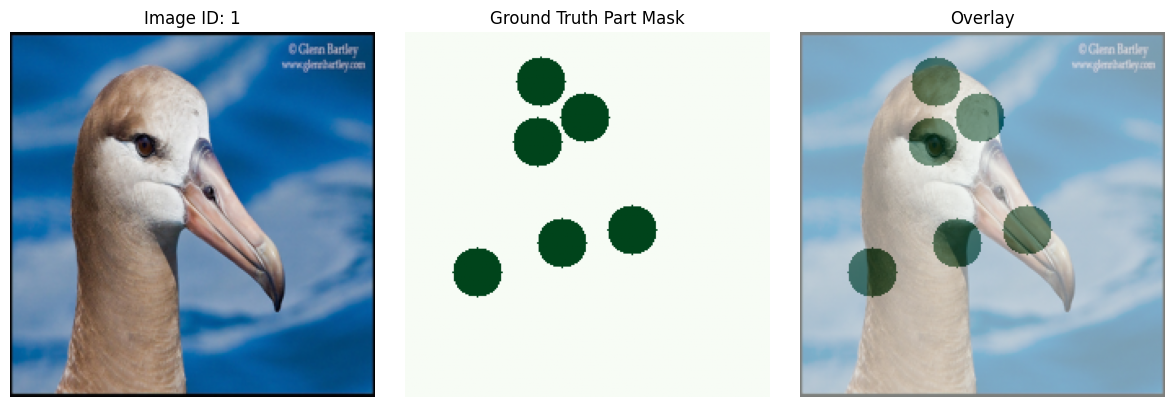

In [5]:
# Visualize a sample with part annotations
sample = test_dataset[0]

fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# Original image
img = denormalize_image(sample['image'])
axes[0].imshow(img)
axes[0].set_title(f"Image ID: {sample['image_id']}")
axes[0].axis('off')

# Class label
class_name = class_names[sample['label']]
axes[0].set_xlabel(f"Class: {class_name}")

# Part mask
axes[1].imshow(sample['part_mask'], cmap='Greens')
axes[1].set_title("Ground Truth Part Mask")
axes[1].axis('off')

# Overlay
axes[2].imshow(img)
axes[2].imshow(sample['part_mask'], cmap='Greens', alpha=0.5)
axes[2].set_title("Overlay")
axes[2].axis('off')

plt.tight_layout()
plt.show()

## 3. Load the CNN Model

We use a ResNet-50 pretrained on ImageNet. For a complete experiment, you should train the model on CUB-200-2011 using `train.py`.

Carichiamo il modello ResNet-50. Se esiste un checkpoint allenato su CUB-200, lo utilizziamo; altrimenti usiamo il modello pre-trained su ImageNet per dimostrazione.

In [6]:
# Try to load trained model, fall back to pretrained
model_path = config.MODELS_DIR / "best_resnet50_cub200.pth"

if model_path.exists():
    print("Loading trained model...")
    model = load_model(str(model_path), model_type='resnet50', device=device)
else:
    print("No trained model found. Using ImageNet pretrained model for demonstration.")
    print("For proper evaluation, run: python train.py")
    model = create_model('resnet50', num_classes=config.NUM_CLASSES, pretrained=True, device=device)

model.eval()
print(f"Model loaded with {sum(p.numel() for p in model.parameters()):,} parameters")

No trained model found. Using ImageNet pretrained model for demonstration.
For proper evaluation, run: python train.py
Model loaded with 23,917,832 parameters


## 4. Initialize Explainability Methods

Inizializziamo la classe `ExplainabilityMethods` che wrappa i metodi di Captum: Integrated Gradients, Input×Gradient, Saliency, LIME, Kernel SHAP e Occlusion.

In [7]:
# Initialize the explainability methods
explainer = ExplainabilityMethods(model, device)

print("Available methods:")
print("  - Integrated Gradients")
print("  - Input × Gradient (Input Gradients)")
print("  - Saliency")
print("  - LIME")
print("  - Kernel SHAP")
print("  - Occlusion")

Available methods:
  - Integrated Gradients
  - Input × Gradient (Input Gradients)
  - Saliency
  - LIME
  - Kernel SHAP
  - Occlusion


## 5. Compute and Visualize Explanations for Sample Images

Definiamo una funzione helper che per un'immagine: (1) calcola la predizione del modello, (2) genera le attribution maps con i vari metodi, (3) visualizza i risultati e (4) calcola le metriche di plausibilità.

In [8]:
def explain_and_visualize(sample_idx, methods=['integrated_gradients', 'input_gradients', 'lime', 'kernel_shap']):
    """Compute and visualize explanations for a single sample."""
    
    sample = test_dataset[sample_idx]
    input_tensor = sample['image'].unsqueeze(0).to(device)
    true_label = sample['label']
    part_mask = sample['part_mask'].numpy()
    
    # Get model prediction
    with torch.no_grad():
        output = model(input_tensor)
        probs = torch.softmax(output, dim=1)
        predicted_class = output.argmax(dim=1).item()
        confidence = probs[0, predicted_class].item()
    
    print(f"Image ID: {sample['image_id']}")
    print(f"True Class: {class_names[true_label]}")
    print(f"Predicted Class: {class_names[predicted_class]} (confidence: {confidence:.2%})")
    print(f"Correct: {predicted_class == true_label}")
    
    # Compute attributions
    print("\nComputing attributions...")
    attributions = {}
    
    for method in tqdm(methods):
        try:
            if method == 'integrated_gradients':
                attr = explainer.get_integrated_gradients(input_tensor, predicted_class)
            elif method == 'input_gradients':
                attr = explainer.get_input_gradients(input_tensor, predicted_class)
            elif method == 'saliency':
                attr = explainer.get_saliency(input_tensor, predicted_class)
            elif method == 'lime':
                attr = explainer.get_lime(input_tensor, predicted_class, n_samples=500)
            elif method == 'kernel_shap':
                attr = explainer.get_kernel_shap(input_tensor, predicted_class, n_samples=50)
            else:
                continue
            attributions[method] = attr
        except Exception as e:
            print(f"Error with {method}: {e}")
            attributions[method] = None
    
    # Visualize
    img = denormalize_image(sample['image'])
    visualize_all_methods(img, attributions, part_mask=part_mask, show=True)
    
    # Compute metrics
    print("\nPlausibility Metrics:")
    for method, attr in attributions.items():
        if attr is not None:
            metrics = compute_all_metrics(attr, part_mask)
            print(f"\n{method}:")
            print(f"  Pointing Game: {metrics['pointing_game']:.3f}")
            print(f"  EBPG: {metrics['ebpg']:.3f}")
            print(f"  AUC-ROC: {metrics['auc_roc']:.3f}")
            print(f"  Mass Accuracy (top 10%): {metrics['mass_accuracy_top10']:.3f}")
    
    return attributions, part_mask

Applichiamo la funzione al primo sample del test set. Osserviamo le heatmap generate e le metriche di plausibilità (Pointing Game, EBPG, AUC-ROC, Mass Accuracy).

LIME è progettato per essere interpretabile dall'umano.
- Il Meccanismo: LIME addestra un modello lineare semplice per approssimare la rete neurale. Di default, usa una tecnica chiamata Lasso (L1 Regularization) o seleziona esplicitamente le "Top-K" feature più importanti.

SHAP si basa sulla Teoria dei Giochi (Valori di Shapley).
- Il Meccanismo: Deve distribuire il "guadagno totale" (la probabilità della classe predetta) tra tutti i "giocatori" (i superpixel).

Image ID: 1
True Class: 001.Black_footed_Albatross
Predicted Class: 094.White_breasted_Nuthatch (confidence: 0.70%)
Correct: False

Computing attributions...


  0%|          | 0/4 [00:00<?, ?it/s]

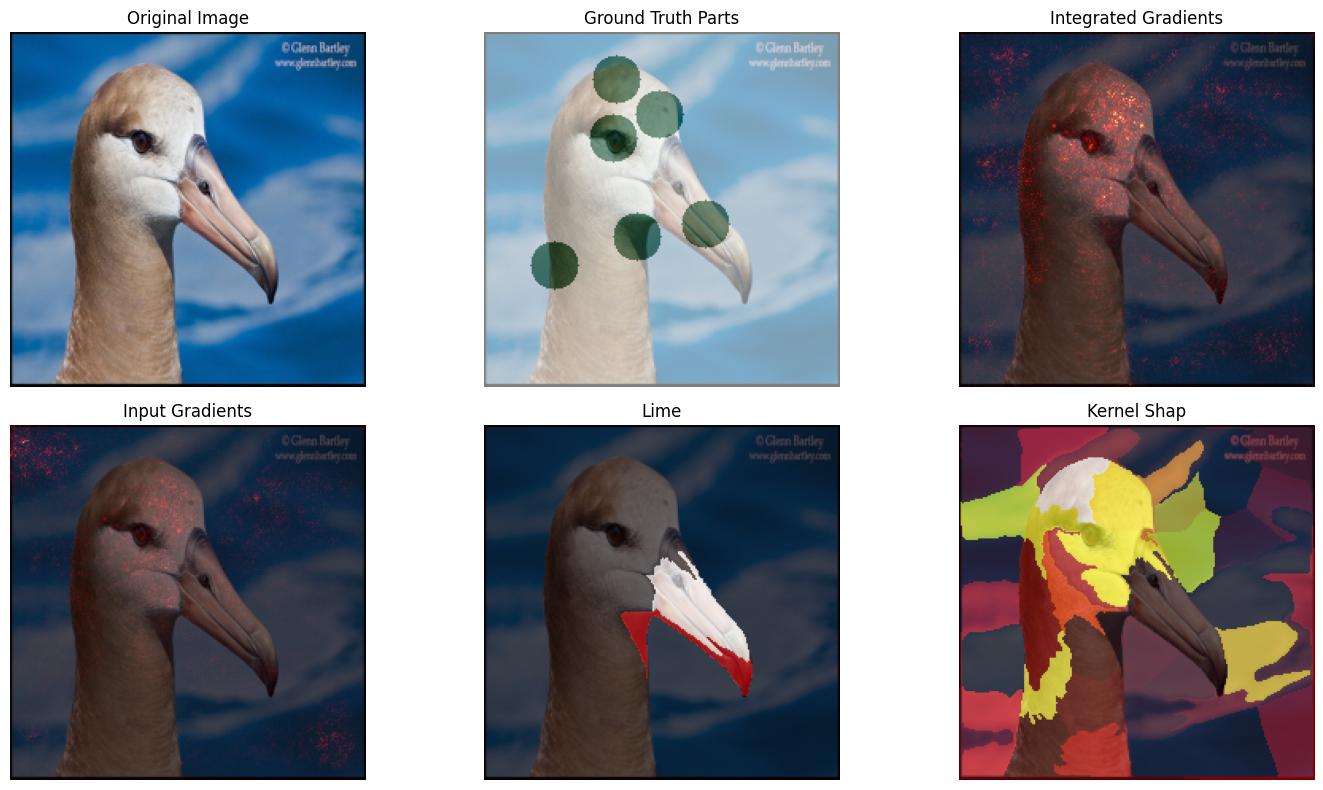


Plausibility Metrics:

integrated_gradients:
  Pointing Game: 1.000
  EBPG: 0.165
  AUC-ROC: 0.689
  Mass Accuracy (top 10%): 0.233

input_gradients:
  Pointing Game: 0.000
  EBPG: 0.133
  AUC-ROC: 0.653
  Mass Accuracy (top 10%): 0.174

lime:
  Pointing Game: 0.000
  EBPG: 0.347
  AUC-ROC: 0.596
  Mass Accuracy (top 10%): 0.085

kernel_shap:
  Pointing Game: 1.000
  EBPG: 0.134
  AUC-ROC: 0.581
  Mass Accuracy (top 10%): 0.192


In [9]:
# Visualize explanations for the first sample
attributions, part_mask = explain_and_visualize(0)

Proviamo con un altro sample (indice 10) per verificare la consistenza dei risultati su immagini diverse.

Image ID: 22
True Class: 001.Black_footed_Albatross
Predicted Class: 042.Vermilion_Flycatcher (confidence: 0.64%)
Correct: False

Computing attributions...


  0%|          | 0/4 [00:00<?, ?it/s]

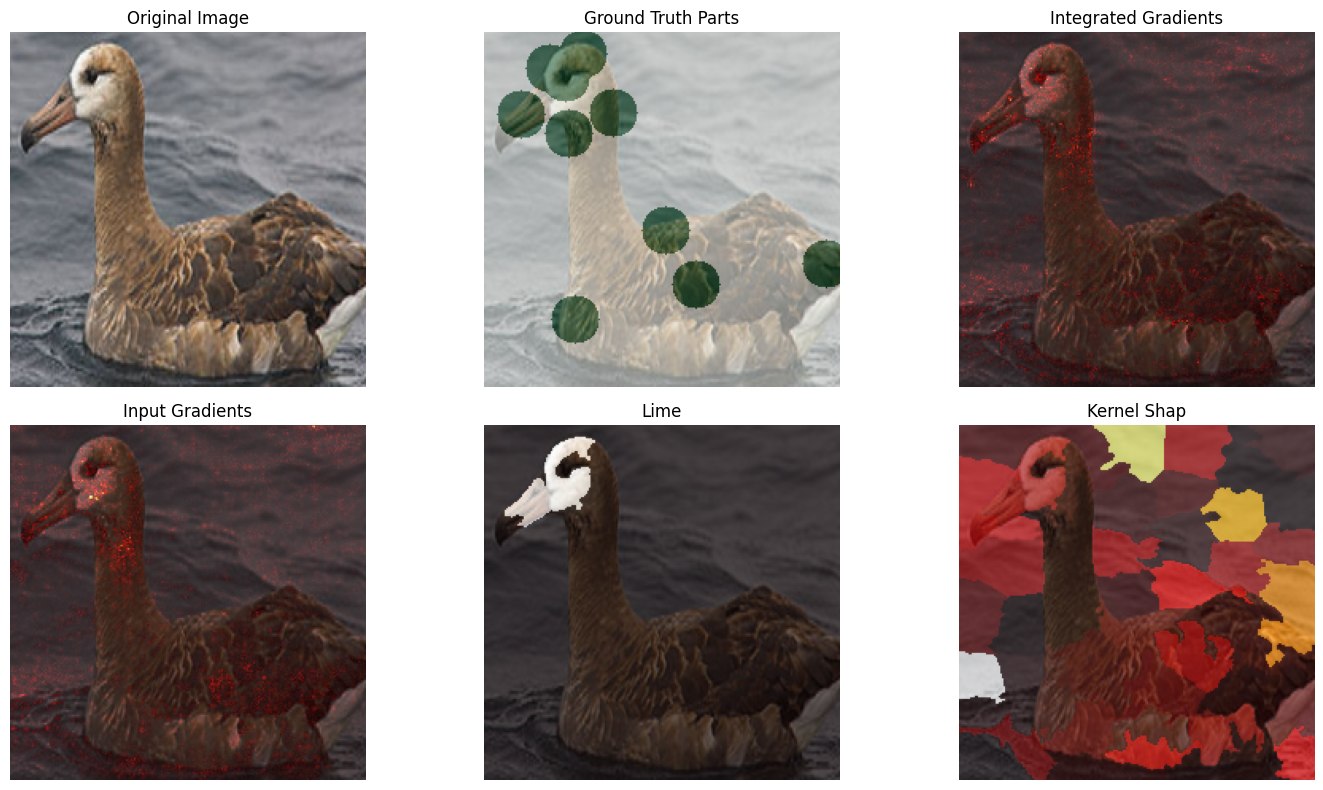


Plausibility Metrics:

integrated_gradients:
  Pointing Game: 1.000
  EBPG: 0.178
  AUC-ROC: 0.573
  Mass Accuracy (top 10%): 0.244

input_gradients:
  Pointing Game: 0.000
  EBPG: 0.174
  AUC-ROC: 0.556
  Mass Accuracy (top 10%): 0.242

lime:
  Pointing Game: 1.000
  EBPG: 0.792
  AUC-ROC: 0.582
  Mass Accuracy (top 10%): 0.128

kernel_shap:
  Pointing Game: 0.000
  EBPG: 0.105
  AUC-ROC: 0.515
  Mass Accuracy (top 10%): 0.036


In [10]:
# Try another sample
attributions2, part_mask2 = explain_and_visualize(10)

## 6. Systematic Evaluation on Multiple Images

Now we evaluate all methods on a larger set of images to get statistical results.

Configuriamo la valutazione sistematica: definiamo il numero di sample e i metodi da confrontare. Inizializziamo il `PlausibilityEvaluator` che raccoglierà tutte le metriche.

NUM_SAMPLES incide molto su metodi perturbativi come LIME e KernelSHAP. Spiegazione:
- Segmentazione: L'immagine viene divisa in, diciamo, 100 tasselli (superpixel).
- Perturbazione (Loop): L'algoritmo deve capire quale tassello è importante. Per farlo, crea n_samples versioni dell'immagine originale oscurando tasselli a caso (es. spegne la testa, poi spegne l'ala, etc.).
- Inferenza (Il collo di bottiglia): Per ognuna di queste versioni perturbate, deve chiedere al modello (ResNet50): "Che uccello è questo?".Se metti n_samples = 1000, il computer deve fare 1000 passaggi (forward pass) dentro la ResNet50 solo per spiegare 1 immagine.Se devi valutare 100 immagini di test, sono $100 \times 1000 = 100.000$ inferenze. È come se processassi un dataset enorme.

La regola empirica è avere samples $> 2 \times$ numero di segmenti. Con 100 segmenti, 300-500 samples è il compromesso minimo per avere stabilità senza aspettare giorni.

In [21]:
# Configuration for evaluation
NUM_SAMPLES = 2  # Increase this for more robust results (e.g., 200-500)
METHODS = ['integrated_gradients', 'input_gradients', 'lime', 'kernel_shap']

# Initialize evaluator
evaluator = PlausibilityEvaluator()

# Random sample indices
indices = np.random.choice(len(test_dataset), min(NUM_SAMPLES, len(test_dataset)), replace=False)

print(f"Evaluating {len(indices)} samples with methods: {METHODS}")

Evaluating 2 samples with methods: ['integrated_gradients', 'input_gradients', 'lime', 'kernel_shap']


Loop di valutazione: per ogni immagine calcoliamo le attribution con tutti i metodi e salviamo i risultati nell'evaluator, includendo predizione del modello e ground-truth.

In [12]:
# Run evaluation
for idx in tqdm(indices, desc="Evaluating samples"):
    sample = test_dataset[idx]
    input_tensor = sample['image'].unsqueeze(0).to(device)
    true_label = sample['label']
    part_mask = sample['part_mask'].numpy()
    image_id = sample['image_id']
    
    # Get model prediction
    with torch.no_grad():
        output = model(input_tensor)
        predicted_class = output.argmax(dim=1).item()
    
    # Compute attributions
    try:
        attributions = explainer.get_all_attributions(
            input_tensor, 
            predicted_class,
            methods=METHODS
        )
        
        # Add to evaluator
        evaluator.add_result(
            image_id=image_id,
            attributions=attributions,
            part_mask=part_mask,
            predicted_class=predicted_class,
            true_class=true_label
        )
    except Exception as e:
        print(f"Error at index {idx}: {e}")

print(f"\nEvaluation complete. Processed {len(evaluator.results)} samples.")

Evaluating samples:   0%|          | 0/2 [00:00<?, ?it/s]


Evaluation complete. Processed 2 samples.


## 7. Results Analysis

Estraiamo i risultati aggregati (media e deviazione standard per ogni metodo) e i risultati dettagliati per ogni singola immagine.

In [13]:
# Get summary results
summary_df = evaluator.get_summary()
detailed_df = evaluator.get_detailed_results()

print("Summary Results:") #TODO: da sistemare dato che sarà complesso runnare su 50 esempi, quindi le descrizioni e le metriche sono errate
display(summary_df)

Summary Results:


,method,pointing_game_mean,pointing_game_std,ebpg_mean,ebpg_std,auc_roc_mean,auc_roc_std,average_precision_mean,average_precision_std,spearman_correlation_mean,...,mass_accuracy_top15_mean,mass_accuracy_top15_std,iou_top20_mean,iou_top20_std,mass_accuracy_top20_mean,mass_accuracy_top20_std,iou_top25_mean,iou_top25_std,mass_accuracy_top25_mean,mass_accuracy_top25_std
0,integrated_gradients,0.5,0.5,0.199761,0.071476,0.663821,0.097646,0.244330,0.113454,0.155330,...,0.195695,0.058323,0.137913,0.042573,0.172081,0.038960,0.132792,0.030781,0.157565,0.025789
1,input_gradients,0.5,0.5,0.168789,0.103062,0.566729,0.201214,0.217440,0.140877,0.051364,...,0.144878,0.105288,0.103954,0.074925,0.126295,0.083151,0.098241,0.064670,0.114477,0.068240
2,lime,0.5,0.5,0.818478,0.181522,0.618223,0.064675,0.246494,0.044851,0.387462,...,0.090980,0.014908,0.090980,0.014908,0.090980,0.014908,0.090980,0.014908,0.090980,0.014908
3,kernel_shap,0.5,0.5,0.140438,0.050546,0.594250,0.040688,0.282097,0.137155,0.096545,...,0.221234,0.098473,0.158916,0.045939,0.197654,0.062050,0.163715,0.020809,0.189051,0.027621


Creiamo bar chart con le metriche medie per ogni metodo. Le barre d'errore indicano la deviazione standard.


Il tuo codice calcola quanto la "mappa di calore" (heatmap) generata dall'algoritmo si sovrappone alla maschera delle parti dell'uccello. Ecco le metriche principali che stai usando:

- Pointing Game (Gioco del Puntatore): È binaria (0 o 1). Prende il pixel più luminoso della spiegazione. Se cade dentro una parte dell'uccello (es. sul becco), è un "Hit" (1). Altrimenti è un "Miss" (0). Misura la capacità di localizzazione "secca".

- EBPG (Energy-Based Pointing Game): È più raffinata. Invece di guardare un solo pixel, somma tutta l'intensità ("energia") della heatmap che cade dentro l'uccello e la divide per l'energia totale.
Esempio: Se EBPG = 0.6, significa che il 60% dell'importanza data dal modello è sull'uccello, e il 40% è disperso sullo sfondo.

- IoU (Intersection over Union): Misura la forma. Prende il top 10% (o 20%) dei pixel più importanti e vede quanto l'area formata si sovrappone perfettamente alla sagoma delle parti dell'uccello.

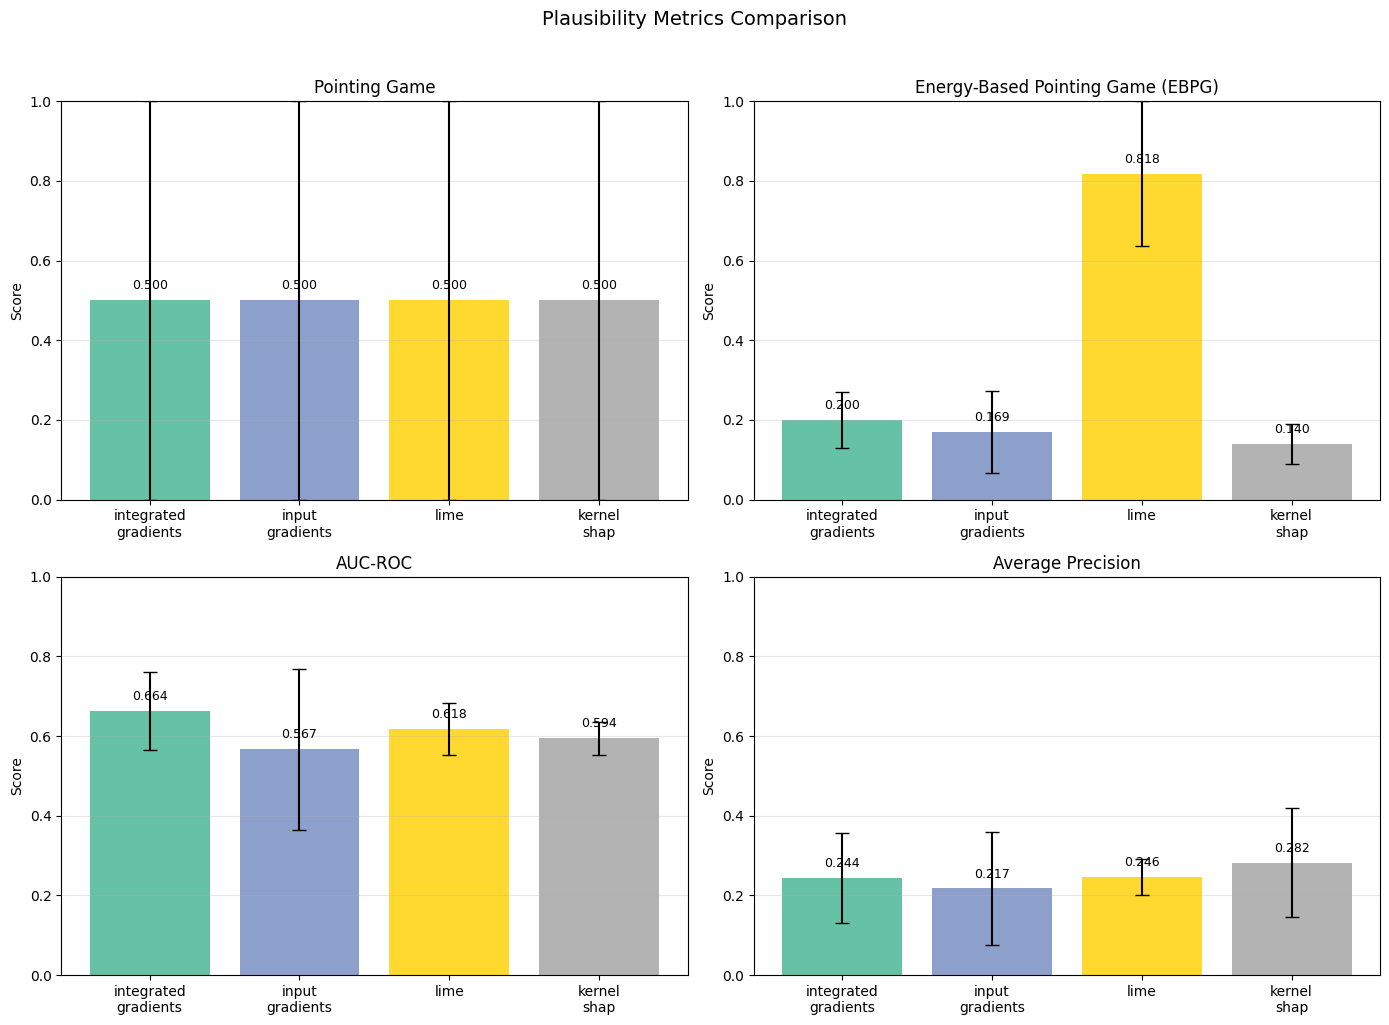

In [14]:
# Visualize key metrics
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

metrics_to_plot = ['pointing_game', 'ebpg', 'auc_roc', 'average_precision']
titles = ['Pointing Game', 'Energy-Based Pointing Game (EBPG)', 'AUC-ROC', 'Average Precision']

for ax, metric, title in zip(axes.flatten(), metrics_to_plot, titles):
    mean_col = f'{metric}_mean'
    std_col = f'{metric}_std'
    
    if mean_col in summary_df.columns:
        methods = summary_df['method'].values
        means = summary_df[mean_col].values
        stds = summary_df[std_col].values
        
        colors = plt.cm.Set2(np.linspace(0, 1, len(methods)))
        bars = ax.bar(range(len(methods)), means, yerr=stds, capsize=5, color=colors)
        ax.set_xticks(range(len(methods)))
        ax.set_xticklabels([m.replace('_', '\n') for m in methods], rotation=0)
        ax.set_ylabel('Score')
        ax.set_title(title)
        ax.set_ylim(0, 1)
        ax.grid(True, alpha=0.3, axis='y')
        
        # Add value labels
        for bar, mean in zip(bars, means):
            ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
                   f'{mean:.3f}', ha='center', va='bottom', fontsize=9)

plt.suptitle('Plausibility Metrics Comparison', fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig(config.RESULTS_DIR / 'metrics_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

Box plot per visualizzare la distribuzione completa delle metriche. Utile per identificare outlier e variabilità tra immagini.

/var/folders/hh/4d4vnlv93k38bb7wfnbpy2b40000gn/T/ipykernel_89119/1394875272.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=detailed_df, x='method', y=metric, ax=ax, palette='Set2')
/var/folders/hh/4d4vnlv93k38bb7wfnbpy2b40000gn/T/ipykernel_89119/1394875272.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([t.get_text().replace('_', '\n') for t in ax.get_xticklabels()])
/var/folders/hh/4d4vnlv93k38bb7wfnbpy2b40000gn/T/ipykernel_89119/1394875272.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=detailed_df, x='method', y=metric, ax=ax, palette='Set2')
/var/folders/hh/4d4v

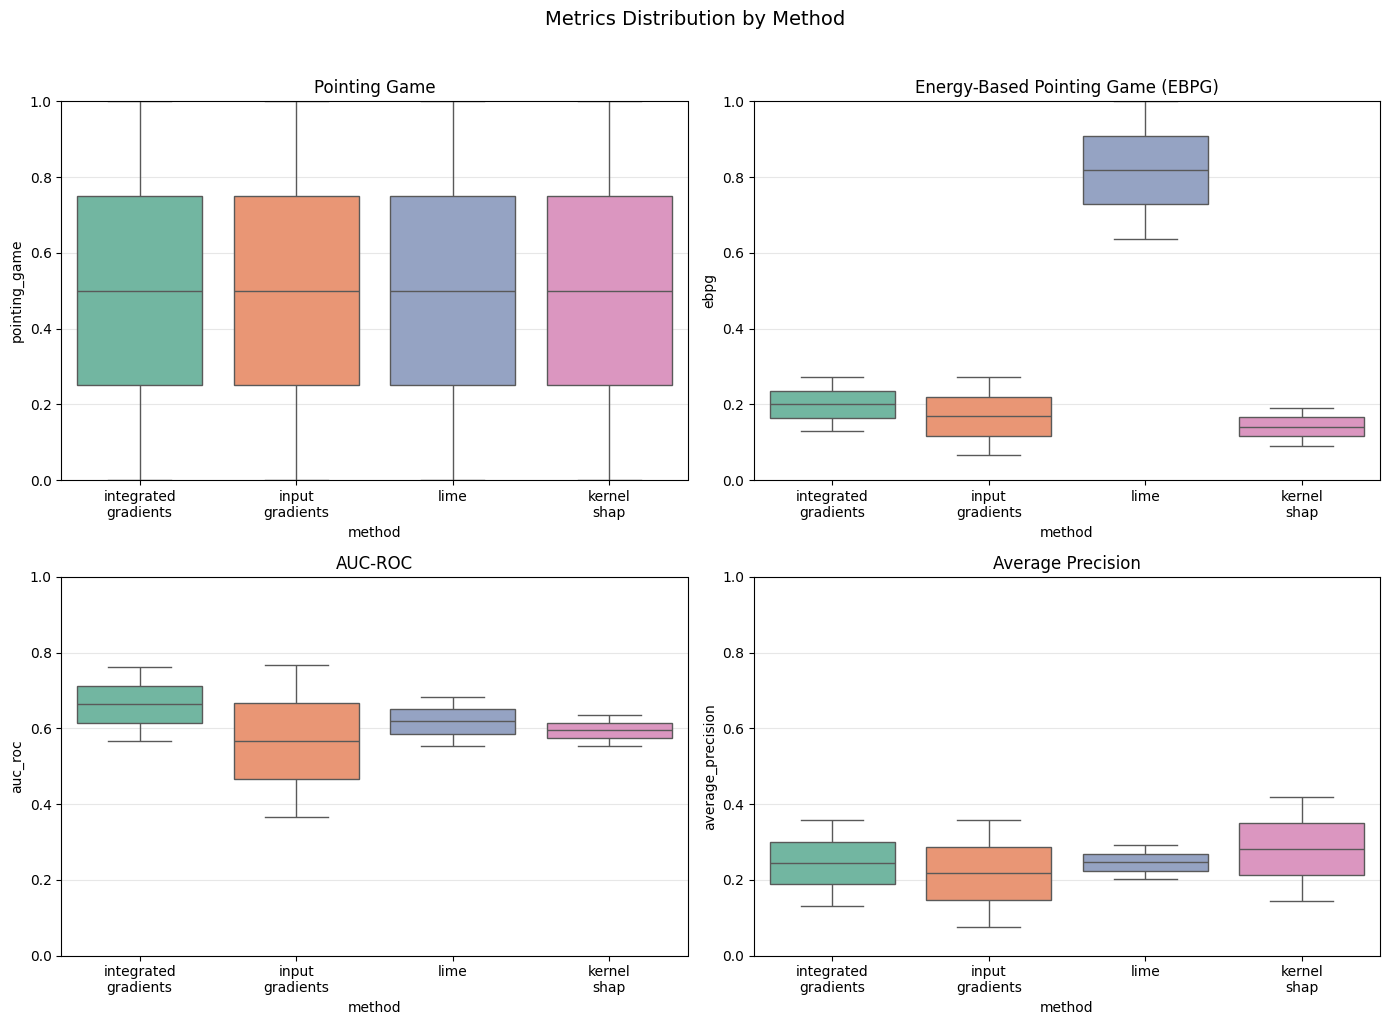

In [15]:
# Box plots for distribution analysis
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

for ax, metric, title in zip(axes.flatten(), metrics_to_plot, titles):
    if metric in detailed_df.columns:
        sns.boxplot(data=detailed_df, x='method', y=metric, ax=ax, palette='Set2')
        ax.set_xticklabels([t.get_text().replace('_', '\n') for t in ax.get_xticklabels()])
        ax.set_title(title)
        ax.set_ylim(0, 1)
        ax.grid(True, alpha=0.3, axis='y')

plt.suptitle('Metrics Distribution by Method', fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig(config.RESULTS_DIR / 'metrics_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

## 8. Analysis: Model vs Explanation Method

**Key Question**: Are the results due to the model or to the explanation method?

We analyze this by comparing explanation quality for:
- **Correct predictions**: The model correctly identified the bird species
- **Incorrect predictions**: The model misclassified the bird

**Interpretation**:
- If explanations are **better for correct predictions**, this suggests the explanation method is **faithful** - it captures what the model actually uses for prediction.
- If there's **no difference**, the explanation method might not be capturing the model's true reasoning.

Separiamo i risultati per predizioni corrette e incorrette. Questo ci permette di capire se le spiegazioni sono **fedeli** al ragionamento del modello.

In [16]:
# Analyze correct vs incorrect predictions
correct_df, incorrect_df = evaluator.get_summary_by_correctness()

print("=" * 60)
print("CORRECT PREDICTIONS")
print("=" * 60)
if not correct_df.empty:
    display(correct_df[['method', 'pointing_game_mean', 'ebpg_mean', 'auc_roc_mean', 'average_precision_mean']])
else:
    print("No correct predictions in sample")

print("\n" + "=" * 60)
print("INCORRECT PREDICTIONS")
print("=" * 60)
if not incorrect_df.empty:
    display(incorrect_df[['method', 'pointing_game_mean', 'ebpg_mean', 'auc_roc_mean', 'average_precision_mean']])
else:
    print("No incorrect predictions in sample")

CORRECT PREDICTIONS
No correct predictions in sample

INCORRECT PREDICTIONS


,method,pointing_game_mean,ebpg_mean,auc_roc_mean,average_precision_mean
0,integrated_gradients,0.5,0.199761,0.663821,0.244330
1,input_gradients,0.5,0.168789,0.566729,0.217440
2,lime,0.5,0.818478,0.618223,0.246494
3,kernel_shap,0.5,0.140438,0.594250,0.282097


Visualizziamo il confronto tra predizioni corrette/incorrette: (1) box plot per vedere le distribuzioni, (2) bar chart con la differenza ΔEBPG.

/var/folders/hh/4d4vnlv93k38bb7wfnbpy2b40000gn/T/ipykernel_89119/3839731022.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels([t.get_text().replace('_', '\n') for t in axes[0].get_xticklabels()])


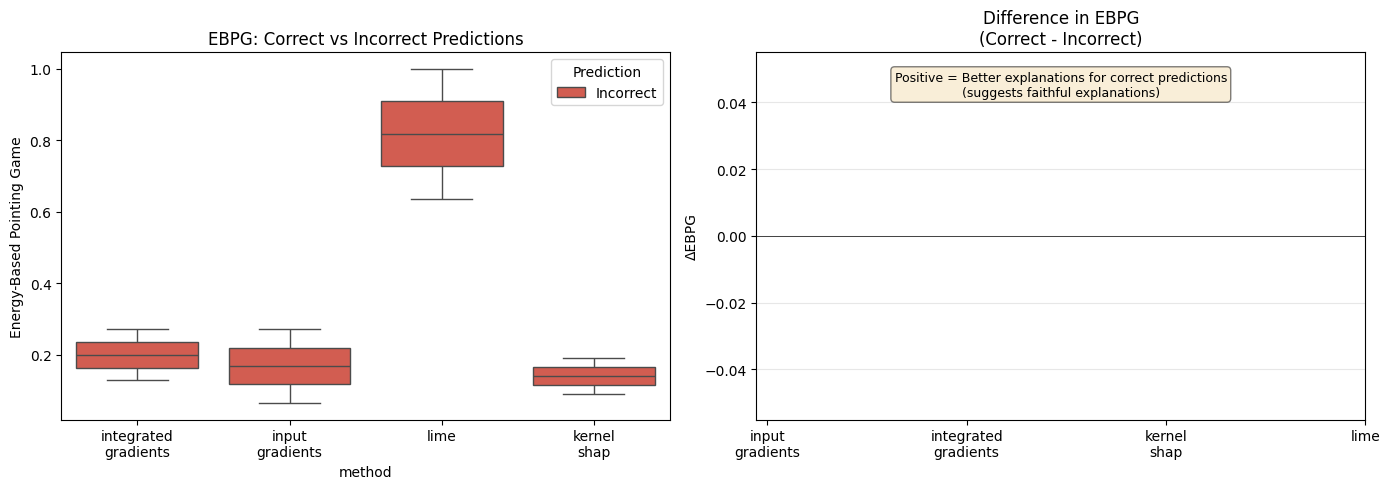

In [17]:
# Visualize correct vs incorrect
if 'correct' in detailed_df.columns:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Box plot
    plot_df = detailed_df.copy()
    plot_df['Prediction'] = plot_df['correct'].map({True: 'Correct', False: 'Incorrect'})
    
    sns.boxplot(data=plot_df, x='method', y='ebpg', hue='Prediction', ax=axes[0],
               palette={'Correct': '#2ecc71', 'Incorrect': '#e74c3c'})
    axes[0].set_xticklabels([t.get_text().replace('_', '\n') for t in axes[0].get_xticklabels()])
    axes[0].set_title('EBPG: Correct vs Incorrect Predictions')
    axes[0].set_ylabel('Energy-Based Pointing Game')
    axes[0].legend(title='Prediction')
    
    # Bar plot of differences
    correct_means = plot_df[plot_df['correct'] == True].groupby('method')['ebpg'].mean()
    incorrect_means = plot_df[plot_df['correct'] == False].groupby('method')['ebpg'].mean()
    
    diff = correct_means - incorrect_means
    colors_diff = ['#2ecc71' if d > 0 else '#e74c3c' for d in diff.values]
    
    bars = axes[1].bar(range(len(diff)), diff.values, color=colors_diff)
    axes[1].set_xticks(range(len(diff)))
    axes[1].set_xticklabels([m.replace('_', '\n') for m in diff.index])
    axes[1].axhline(y=0, color='black', linestyle='-', linewidth=0.5)
    axes[1].set_title('Difference in EBPG\n(Correct - Incorrect)')
    axes[1].set_ylabel('ΔEBPG')
    axes[1].grid(True, alpha=0.3, axis='y')
    
    # Add interpretation
    axes[1].text(0.5, 0.95, 
                "Positive = Better explanations for correct predictions\n(suggests faithful explanations)",
                transform=axes[1].transAxes, ha='center', va='top', fontsize=9,
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    plt.tight_layout()
    plt.savefig(config.RESULTS_DIR / 'correct_vs_incorrect.png', dpi=150, bbox_inches='tight')
    plt.show()

Test statistico (Wilcoxon signed-rank) per verificare se le differenze tra metodi sono significative. Utile per stabilire un ranking robusto.

In [18]:
# Statistical comparison between methods
comparison = evaluator.compare_methods(metric='ebpg')

print("Statistical Comparison (Wilcoxon signed-rank test on EBPG):")
print("=" * 70)

for _, row in comparison.iterrows():
    sig = "***" if row['wilcoxon_pvalue'] < 0.001 else "**" if row['wilcoxon_pvalue'] < 0.01 else "*" if row['wilcoxon_pvalue'] < 0.05 else ""
    better = row['method1'] if row['mean_diff'] > 0 else row['method2']
    print(f"{row['method1']} vs {row['method2']}:")
    print(f"  Mean difference: {row['mean_diff']:.4f}")
    print(f"  p-value: {row['wilcoxon_pvalue']:.4f} {sig}")
    print(f"  Better: {better}")
    print()

Statistical Comparison (Wilcoxon signed-rank test on EBPG):
integrated_gradients vs input_gradients:
  Mean difference: 0.0310
  p-value: 1.0000 
  Better: integrated_gradients

integrated_gradients vs lime:
  Mean difference: -0.6187
  p-value: 0.5000 
  Better: lime

integrated_gradients vs kernel_shap:
  Mean difference: 0.0593
  p-value: 1.0000 
  Better: integrated_gradients

input_gradients vs lime:
  Mean difference: -0.6497
  p-value: 0.5000 
  Better: lime

input_gradients vs kernel_shap:
  Mean difference: 0.0284
  p-value: 1.0000 
  Better: input_gradients

lime vs kernel_shap:
  Mean difference: 0.6780
  p-value: 0.5000 
  Better: lime



## 9. Conclusions

### Summary of Findings

Stampiamo il ranking finale dei metodi per EBPG e l'analisi della fedeltà: per ogni metodo confrontiamo EBPG su predizioni corrette vs incorrette.

In [19]:
# Print final summary
print("=" * 70)
print("FINAL SUMMARY: EXPLAINABILITY METHODS COMPARISON")
print("=" * 70)

# Rank methods by EBPG
if 'ebpg_mean' in summary_df.columns:
    ranked = summary_df.sort_values('ebpg_mean', ascending=False)
    
    print("\nRanking by Energy-Based Pointing Game (EBPG):")
    print("-" * 50)
    for rank, (_, row) in enumerate(ranked.iterrows(), 1):
        print(f"{rank}. {row['method']}: {row['ebpg_mean']:.4f} ± {row['ebpg_std']:.4f}")

# Model accuracy
accuracy = detailed_df['correct'].mean() * 100 if 'correct' in detailed_df.columns else None
if accuracy:
    print(f"\nModel Accuracy on evaluated samples: {accuracy:.1f}%")

# Key insight
print("\n" + "=" * 70)
print("KEY INSIGHT: Model vs Explanation Method")
print("=" * 70)

if 'correct' in detailed_df.columns:
    for method in METHODS:
        method_data = detailed_df[detailed_df['method'] == method]
        correct_ebpg = method_data[method_data['correct'] == True]['ebpg'].mean()
        incorrect_ebpg = method_data[method_data['correct'] == False]['ebpg'].mean()
        diff = correct_ebpg - incorrect_ebpg
        
        interpretation = "FAITHFUL (captures model reasoning)" if diff > 0.05 else \
                        "POSSIBLY NOT FAITHFUL" if diff < -0.05 else "INCONCLUSIVE"
        
        print(f"\n{method}:")
        print(f"  EBPG (correct): {correct_ebpg:.4f}")
        print(f"  EBPG (incorrect): {incorrect_ebpg:.4f}")
        print(f"  Difference: {diff:+.4f}")
        print(f"  Interpretation: {interpretation}")

FINAL SUMMARY: EXPLAINABILITY METHODS COMPARISON

Ranking by Energy-Based Pointing Game (EBPG):
--------------------------------------------------
1. lime: 0.8185 ± 0.1815
2. integrated_gradients: 0.1998 ± 0.0715
3. input_gradients: 0.1688 ± 0.1031
4. kernel_shap: 0.1404 ± 0.0505

KEY INSIGHT: Model vs Explanation Method

integrated_gradients:
  EBPG (correct): nan
  EBPG (incorrect): 0.1998
  Difference: +nan
  Interpretation: INCONCLUSIVE

input_gradients:
  EBPG (correct): nan
  EBPG (incorrect): 0.1688
  Difference: +nan
  Interpretation: INCONCLUSIVE

lime:
  EBPG (correct): nan
  EBPG (incorrect): 0.8185
  Difference: +nan
  Interpretation: INCONCLUSIVE

kernel_shap:
  EBPG (correct): nan
  EBPG (incorrect): 0.1404
  Difference: +nan
  Interpretation: INCONCLUSIVE


Salviamo tutti i risultati in file CSV per analisi future e riproducibilità.

In [20]:
# Save results
summary_df.to_csv(config.RESULTS_DIR / 'summary_results.csv', index=False)
detailed_df.to_csv(config.RESULTS_DIR / 'detailed_results.csv', index=False)

print(f"\nResults saved to {config.RESULTS_DIR}")
print("\nFiles created:")
print("  - summary_results.csv")
print("  - detailed_results.csv")
print("  - metrics_comparison.png")
print("  - metrics_distribution.png")
print("  - correct_vs_incorrect.png")


Results saved to /Users/filippostanghellini/GitHub/Explainability-project/results

Files created:
  - summary_results.csv
  - detailed_results.csv
  - metrics_comparison.png
  - metrics_distribution.png
  - correct_vs_incorrect.png


## 10. Discussion Questions

Based on the results, consider the following questions:

1. **Which method produces the most plausible explanations?** (Highest alignment with ground-truth parts)

2. **Are the differences between methods statistically significant?**

3. **Is explanation quality higher for correct predictions?** 
   - If yes: The explanation method likely captures what the model actually uses
   - If no: The explanation might not be faithful to the model's reasoning

4. **Trade-offs between methods:**
   - Gradient-based (IG, Input Gradients): Fast but may be noisy
   - Perturbation-based (LIME, SHAP): Slower but potentially more interpretable

5. **Limitations of this evaluation:**
   - Part annotations are just one aspect of what defines a bird species
   - The model might use features not captured by part locations (e.g., texture, background)
   - Plausibility ≠ Faithfulness (explanations can be plausible without being faithful)